In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cma
from es import *
from electrolyser import Electrolyser
from network_arch import Agent
from simulation import get_agent_working_result, estimate_results

In [2]:
agent = Agent()

In [3]:

def apply_solution(solution):

    agent.updateParams(solution)

    [total_Production_in_dinamics,
     desired_total_Production_in_dinamics,
     Production_Error_in_dinamics,

     total_cost_of_work_for_elecs,
     total_run_out_for_elecs,

     Outs,
     Temperatures,
     States,
     Targets,
     switch_nums_for_elecs,
     Control_signals,

     Output_derivative_for_elecs,
     Output_dderivative_for_elecs]                                       = get_agent_working_result(agent)

    return [Production_Error_in_dinamics, total_run_out_for_elecs, switch_nums_for_elecs,
            total_Production_in_dinamics, desired_total_Production_in_dinamics]


In [4]:
param_count = 0
for param in agent.model.parameters():
  print(param.data.shape)
  param_count += np.product(param.data.shape)
print(param_count)

torch.Size([50, 99])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])
8060


In [5]:
solution = np.random.rand(8060,1) * 6 - 3 # случайное решение можно оценить до начала обучения

In [6]:
import pickle

In [7]:

file_model = open('serialised_data_CMAES_MarkovDelta_t/best_model_relu_linear_norm_2out.pkl', 'rb')
file_params = open('serialised_data_CMAES_MarkovDelta_t/best_params_relu_linear_norm_2out.pkl', 'rb')
file_es = open('serialised_data_CMAES_MarkovDelta_t/evalution_strategy_relu_linear_norm_2out.pkl', 'rb')
file_log = open('serialised_data_CMAES_MarkovDelta_t/logs_relu_linear_norm_2out.pkl', 'rb')
#file_dict_score_solution = open('serialised_data_CMAES_MarkovDelta_t/score_solution_relu_linear_norm_2out.pkl', 'rb')

best_model = pickle.load(file_model)
best_params = pickle.load(file_params)
old_es = pickle.load(file_es)
data_log = pickle.load(file_log)
#dict_score_solution_old_3100 = pickle.load(file_dict_score_solution)

file_model.close()
file_params.close()
file_es.close()
file_log.close()
#file_dict_score_solution.close()


In [8]:
data_log1 = data_log.copy()

es = old_es

agent.updateParams(best_params)


In [9]:
# PEPG, CMA ES, SimpleGA search

# sigma_init = 0.5 # 0.1
#
# popsize = 50
#
# es = CMAES(num_params=param_count, sigma_init = sigma_init, popsize=popsize)
#
# data_log1 = []
#
# dict_score_solution = []

dict_score_solution = []

In [10]:

def train_for_some_generations(generations_num):

    for i in range(generations_num):

        solutions = es.ask()

        reward_list = []

        solut_number = 0
        for solution in solutions: # можно параллельно

            [Production_Error_in_dinamics, total_run_out_for_elecs, switch_nums_for_elecs,
            total_Production_in_dinamics, desired_total_Production_in_dinamics] = apply_solution(solution)
            score = estimate_results([Production_Error_in_dinamics, total_run_out_for_elecs])[0] # get cost functions value at point solution

            reward_list.append(score)

            print(str(solut_number) + ' solution is aplied, score = ' + str(score) + '  min-max = ' + str(min(solution)) + ' -- ' + str(max(solution)))

            dict_score_solution.append([score, solution])

            solut_number += 1

        es.tell(reward_list)

        my_reward = max(reward_list) # min with '-'

        es_solution = es.result()

        reward = es_solution[1] # best reward
        curr_reward = es_solution[2] # best of the current batch

        print(str(i) + "  ==>>",end=' ')
        print(my_reward,end=' === ')
        print(es_solution[0].mean(), end=' === ')
        print(es.rms_stdev(), end=' === ')

        print(reward, end=' === ')
        print(curr_reward)

        data_log1.append(my_reward)
        # data_log2.append(reward)
        # data_log3.append(curr_reward)

        # if abs(13-my_reward) <= 0.01 or abs(13-reward) <= 0.01 or i >= 1000: # todo
        #     break


    return [es.result()[0], es.current_param(), data_log1] # best historical solution

# PEPG search

# максимизируем функцию estimate_sulution(solution)

# 3000h in steady equal to 500h in cycling as a ratio and the cycle length could be 2h On 4h Off




In [20]:
%%time

train_Report = train_for_some_generations(1)

0 solution is aplied, score = -6414.88600614633  min-max = -6.11704941325724 -- 5.600619680716786
1 solution is aplied, score = -5320.468145738141  min-max = -6.8818140988633125 -- 6.10823438208665
2 solution is aplied, score = -6590.23565696779  min-max = -5.380667511226409 -- 5.199978181678627
3 solution is aplied, score = -6583.689477354542  min-max = -6.264315610052908 -- 5.168366429007174
4 solution is aplied, score = -5828.317950209521  min-max = -6.068419886806712 -- 5.192817589780794
5 solution is aplied, score = -5048.3397193238825  min-max = -6.067342284595586 -- 5.894931401018371
6 solution is aplied, score = -5996.8520556773865  min-max = -6.436223530751048 -- 6.032304662453901
7 solution is aplied, score = -6355.409578879396  min-max = -6.279185732708086 -- 5.591826591232855
8 solution is aplied, score = -9488.24277039609  min-max = -5.834278844668232 -- 6.744911838458861
9 solution is aplied, score = -6202.742534664589  min-max = -5.720097917765862 -- 5.525228632700546
10

In [21]:
curr_solution = train_Report[1]

In [22]:
print(len(dict_score_solution))
print(len(data_log1))

100
156


In [23]:
%%time

[Production_Error_in_dinamics, total_run_out_for_elecs, switch_nums_for_elecs,
            total_Production_in_dinamics, desired_total_Production_in_dinamics] = apply_solution(best_params)

[neg_J, RMSE, mean_error, asymetric_error, max_total_run_out, run_out_deviation_RMSE] = estimate_results([Production_Error_in_dinamics, total_run_out_for_elecs])

print('=========================== SCORE')
print('neg_J = ' + str(neg_J))
print('RMSE = ' + str(RMSE))
print('mean_error = ' + str(mean_error))
print('asymetric_error = ' + str(asymetric_error))
print('max_total_run_out = ' + str(max_total_run_out))
#print(min_max_tot_run_out)
print('run_out_deviation_RMSE = ' + str(run_out_deviation_RMSE))
print("switc num = ", end=' ')
print(switch_nums_for_elecs)
print(sum(switch_nums_for_elecs))



=========================== SCORE
neg_J = -5543.3538046219
RMSE = 182.13360685260713
mean_error = -14.34348849236234
asymetric_error = 2.898813952183163
max_total_run_out = 7631.900000007858
run_out_deviation_RMSE = 3052.760000003143
switc num =  [1 1 1 1 0]
4
CPU times: user 2.05 s, sys: 8 ms, total: 2.05 s
Wall time: 2.06 s


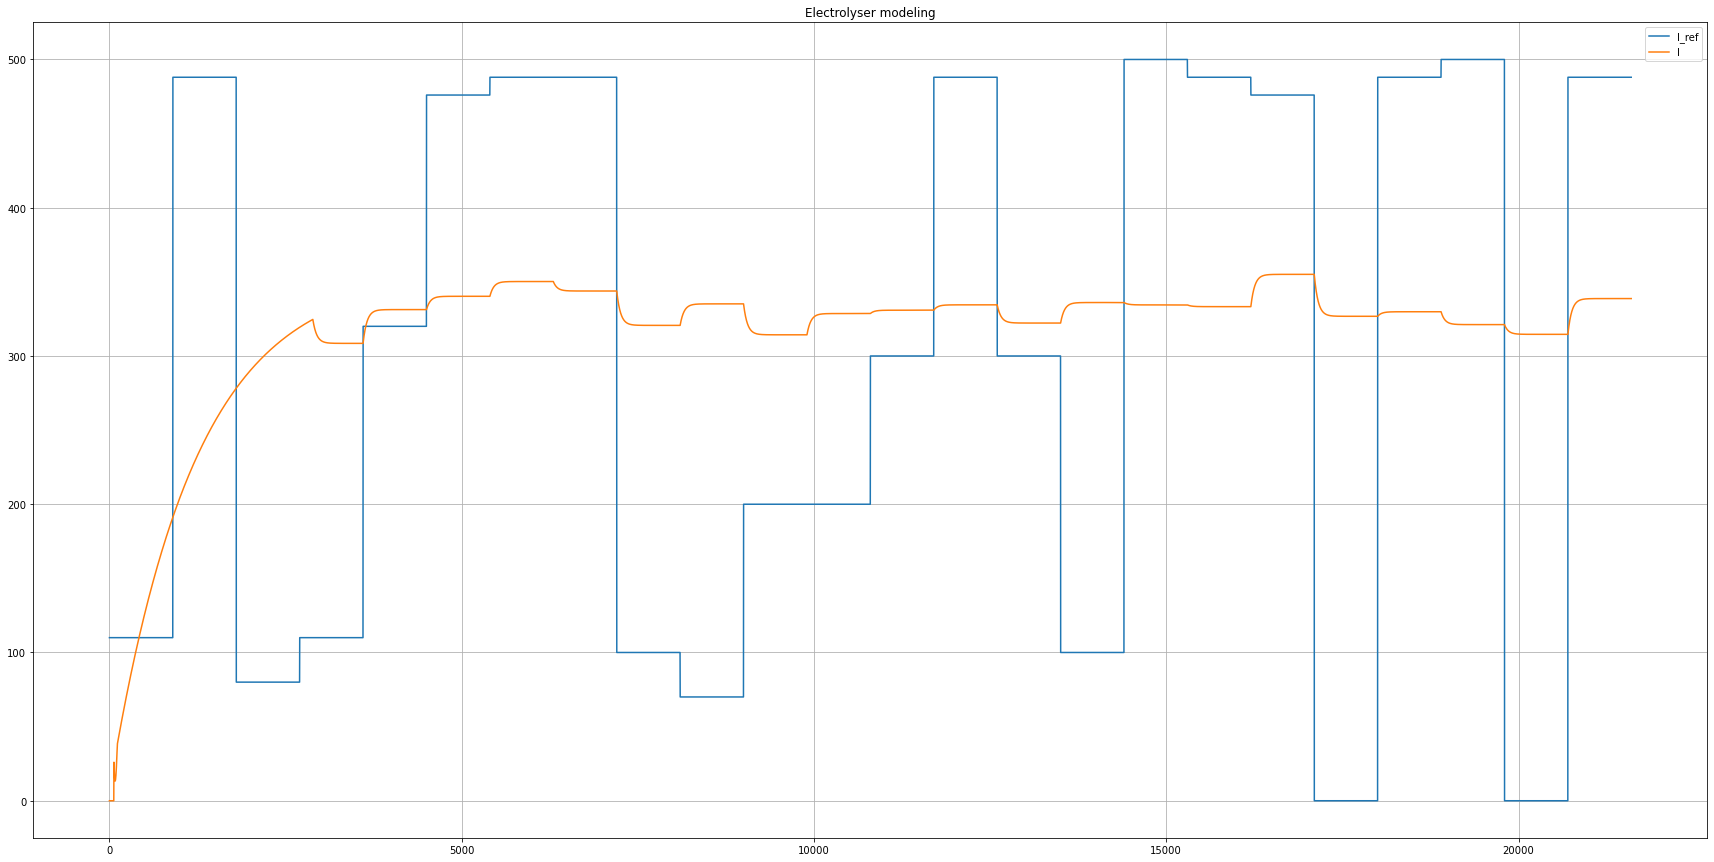

In [24]:
plt.figure(figsize=(30, 15))
plt.title("Electrolyser modeling")
plt.plot(desired_total_Production_in_dinamics, label='I_ref')
plt.plot(total_Production_in_dinamics, label='I')

plt.legend()
plt.grid(visible=True)

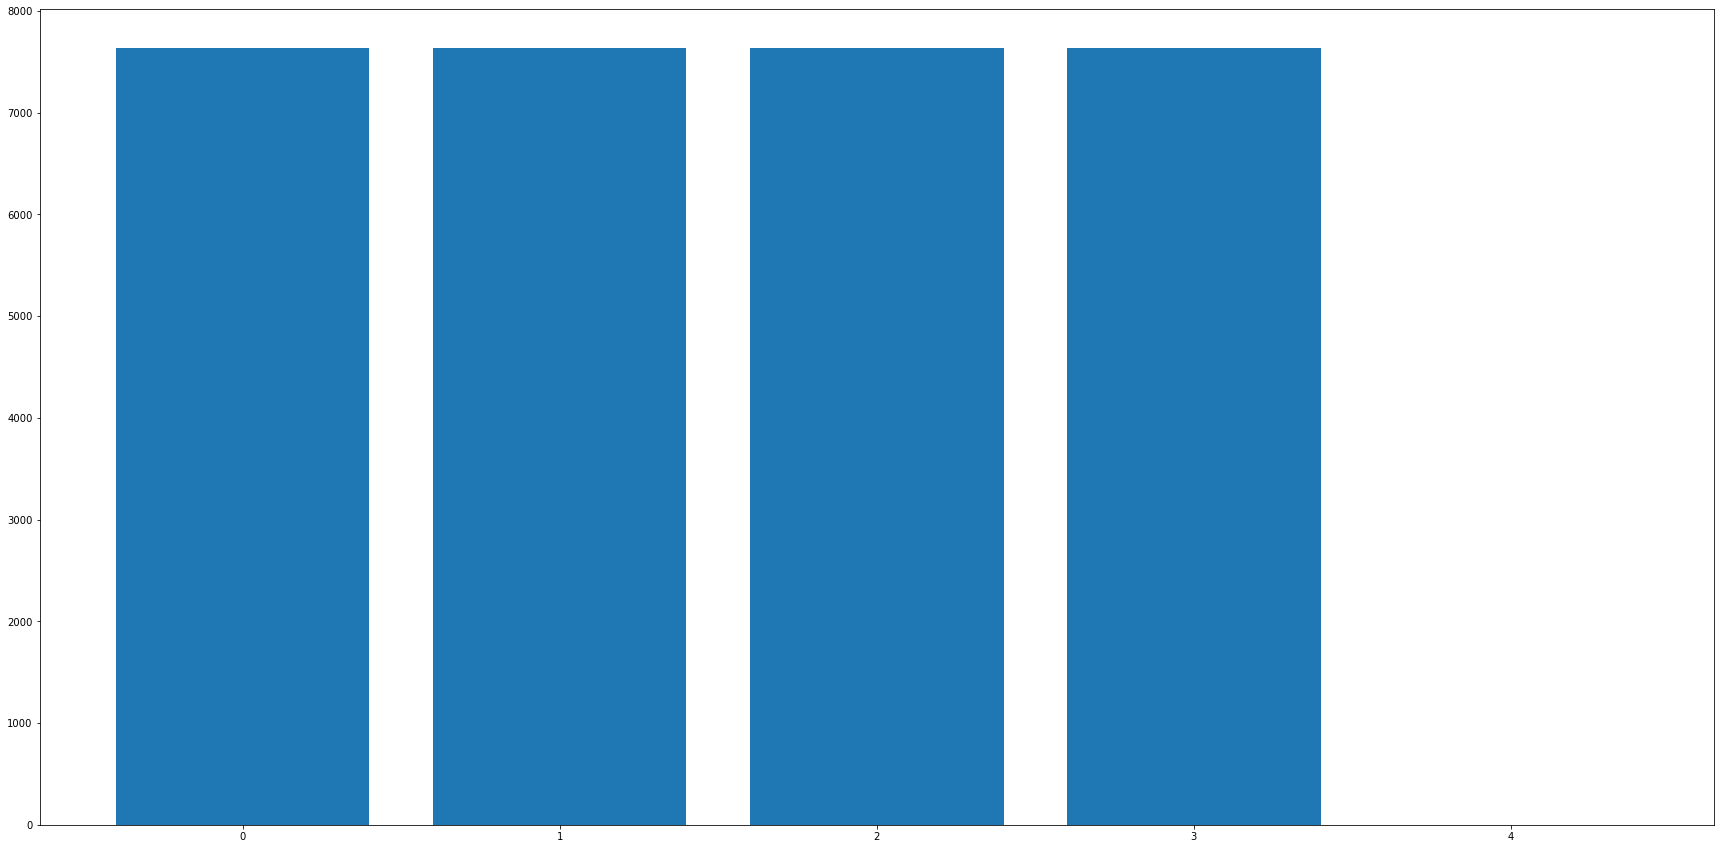

In [25]:
num_elecs = 5
names = list(range(num_elecs))
values = total_run_out_for_elecs

plt.figure(figsize=(30, 15))
plt.bar(names, values)
plt.show()

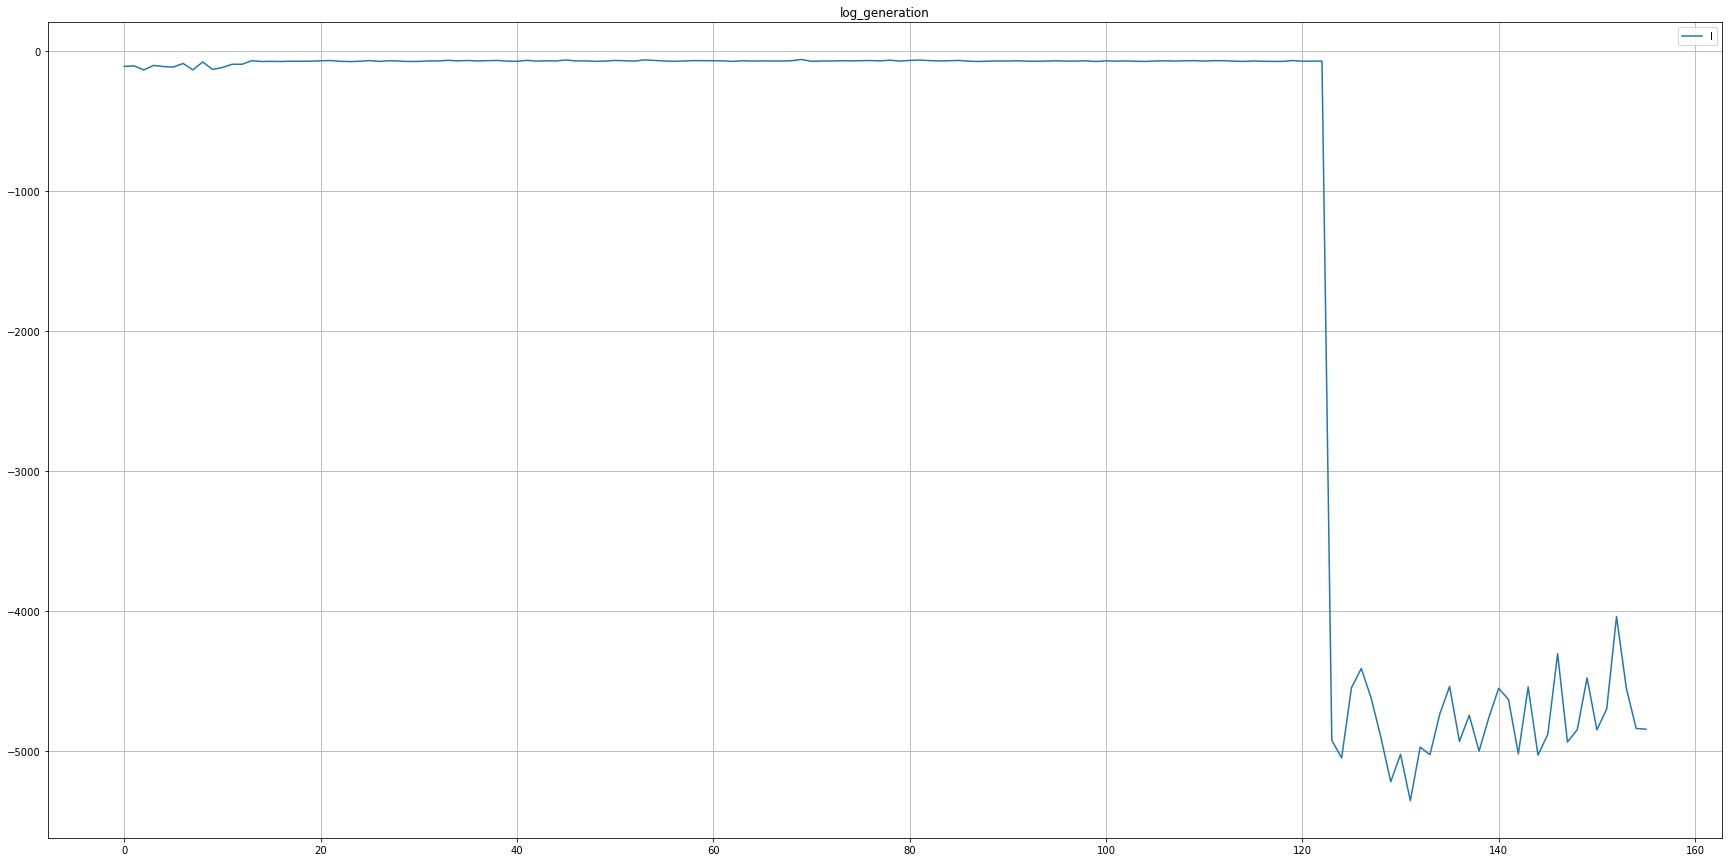

In [26]:
plt.figure(figsize=(30, 15))
plt.title("log_generation")
plt.plot(data_log1, label='I')

plt.legend()
plt.grid(visible=True)

In [27]:
import pickle

In [28]:


file_model = open('serialised_data_CMAES_MarkovDelta_t/best_model_relu_linear_norm_2out.pkl', 'wb')
file_params = open('serialised_data_CMAES_MarkovDelta_t/best_params_relu_linear_norm_2out.pkl', 'wb')
file_es = open('serialised_data_CMAES_MarkovDelta_t/evalution_strategy_relu_linear_norm_2out.pkl', 'wb')
file_log = open('serialised_data_CMAES_MarkovDelta_t/logs_relu_linear_norm_2out.pkl', 'wb')
file_dict_score_solution = open('serialised_data_CMAES_MarkovDelta_t/score_solution_relu_linear_norm_2out__number2.pkl', 'wb')

pickle.dump(agent.model, file_model)
pickle.dump(curr_solution,file_params)
pickle.dump(es, file_es)
pickle.dump(data_log1, file_log)
pickle.dump(dict_score_solution, file_dict_score_solution)

file_model.close()
file_params.close()
file_es.close()
file_log.close()
file_dict_score_solution.close()

